In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Dict, List
from pathlib import Path
import ast

import sys
sys.path.append("..")
from main import get_output_nodes
from scipy.signal import savgol_filter

import matplotlib
matplotlib.rcParams.update({'font.size': 14})


[2023-05-02 13:01:42-SIMPLE_CACHE-DEBUG] Caching function '/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/notebooks/../main.py/get_weights_lr' at '/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/notebooks/../.main.py/get_weights_lr' (cache_fn.py:_lazy_instantiate:36)


In [2]:
nodes = ['AOD', 'CarbonMonoxide', 'FIRE', 'LAI', 'LSTD_AN', 'LSTN_AN', 'WV']
print(nodes)


['AOD', 'CarbonMonoxide', 'FIRE', 'LAI', 'LSTD_AN', 'LSTN_AN', 'WV']


In [3]:
def rel(baseline, x):
    return ((baseline / x) - 1) * 100

def rel_std(baseline_l2, baseline_std, x_l2, x_std):
    x_rel = rel(baseline_l2, x_l2)
    A = rel(baseline_l2 - baseline_std, x_l2 - x_std) - x_rel
    B = -rel(baseline_l2 + baseline_std, x_l2 + x_std) + x_rel
    return abs((A + B) / 2)

def get_it1_sl_score(node: str, it1_dir) -> pd.Series:
    edges = pd.read_csv(f"{it1_dir}/{node}_results_edges_test.csv",
                         converters={"l2_each": lambda x: np.array(ast.literal_eval(x), dtype=np.float32)})
    edges = edges[edges["edges"].str.contains("Single Link")]
    edges = edges.set_index("edges")
    edges = edges.sort_values("l2")
    res = edges.iloc[0]
    return res[["l2_each"]]

def get_it2_sl_score(node: str, it2_dir, it1_sl_score: pd.Series) -> pd.Series:
    edges = pd.read_csv(f"{it2_dir}/{node}_results_edges_test.csv", index_col=0,
                        converters={"l2_each": lambda x: np.array(ast.literal_eval(x), dtype=np.float32)})
    it2_sl_score = edges.loc[it1_sl_score.name]
    return it2_sl_score[["l2_each"]]

def get_it2_ens_score(node, variant: str, it2_dir) -> pd.Series:
    assert variant in ("nn_small_v2", "simple_mean", "weighted_mean_lr"), variant
    edges = pd.read_csv(f"{it2_dir}/{node}_results_{variant}.csv", index_col=0,
                        converters={"l2_each": lambda x: np.array(ast.literal_eval(x), dtype=np.float32)})
    it2_sl_score = edges.sort_values("l2").iloc[0]
    return it2_sl_score[["l2_each"]]

In [4]:
def read_ens_data(paths, node):
    res = {}
    for variant, variant_paths in paths.items():
        baseline = get_it1_sl_score(node, variant_paths[0])
        it1_ens = get_it2_ens_score(node, variant, variant_paths[1])
        it2_ens = get_it2_ens_score(node, variant, variant_paths[2])
        res[variant] = np.array([baseline["l2_each"], it1_ens["l2_each"], it2_ens["l2_each"]])
    return res

def read_sl_data(paths, node):
    res = {}
    for variant, variant_paths in paths.items():
        baseline = get_it1_sl_score(node, variant_paths[0])
        it2_sl = get_it2_sl_score(node, variant_paths[1], baseline)
        it3_sl = get_it2_sl_score(node, variant_paths[2], baseline)
        res[variant] = np.array([baseline["l2_each"], it2_sl["l2_each"], it3_sl["l2_each"]])
    return res

## 84 months

In [5]:
sl_paths = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it1_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it2_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it3_nn_test_train_right",
    ]
}

ens_paths = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it1_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it1_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it2_nn_test_train_right",
    ]

}

def get_average(non_avg_data: Dict[str, np.ndarray]) -> np.ndarray:
    """data: """
    return np.stack(list(non_avg_data.values())).mean(axis=0)

def year_avg(data):
    res = data * 0
    assert data.shape[-1] % 12 == 0
    n = data.shape[-1] // 12
    for i in range(n):
        res[:, i * 12: (i + 1) * 12] = (data[:, i * 12: (i + 1) * 12].mean(axis=1))[:, None]
    return res

active_method = "nn_small_v2"
sup_title = {"nn_small_v2": "NN-V2", "simple_mean": "S-Mean", "weighted_mean_lr": "S-LR"}[active_method]
nodes = ['AOD', 'FIRE', 'LSTD_AN', 'LSTN_AN', 'WV']

_sl_paths = {active_method: sl_paths[active_method]}
sl_data = {node: read_sl_data(_sl_paths, node)[active_method] for node in nodes}
sl_data = {node: v[:, 0:84] for node, v in sl_data.items()}
print("Node => 3 iters and 84 months: ", {node: v.shape for node, v in sl_data.items()})


# avg_sl_data = get_average(sl_data)
# print(f"avg sl data : {avg_sl_data.shape}")

# year_sl_data = year_avg(avg_sl_data)
# print(f"year sl avg data : {avg_sl_data.shape}")

# # print(f"ens data : {avg_ens_data.shape}")
# xticks = [[0, 12, 24, 36, 48, 60, 72, 84],
#          ["2014-09", "2015-09", "2016-09", "2017-09", "2018-09", "2019-09",  "2020-09", "2021-09"] ]

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# f_plot(ax[0], avg_sl_data, None, title="Edges", legend=False, colors=["blue", "orange", "green"], xticks=xticks)
# f_plot(ax[1], avg_ens_data, None, title="Ensembles", legend=True, colors=["blue", "orange", "green"], xticks=xticks)
# fig.suptitle(sup_title)


Node => 3 iters and 84 months:  {'AOD': (3, 84), 'FIRE': (3, 84), 'LSTD_AN': (3, 84), 'LSTN_AN': (3, 84), 'WV': (3, 84)}


Node => 3 iters and 84 months:  {'AOD': (3, 84), 'FIRE': (3, 84), 'LSTD_AN': (3, 84), 'LSTN_AN': (3, 84), 'WV': (3, 84)}
Node => 84 months of it2 and it3 relative to it1:  {'AOD': (2, 84), 'FIRE': (2, 84), 'LSTD_AN': (2, 84), 'LSTN_AN': (2, 84), 'WV': (2, 84)}
avg l2 sl data : (3, 84)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


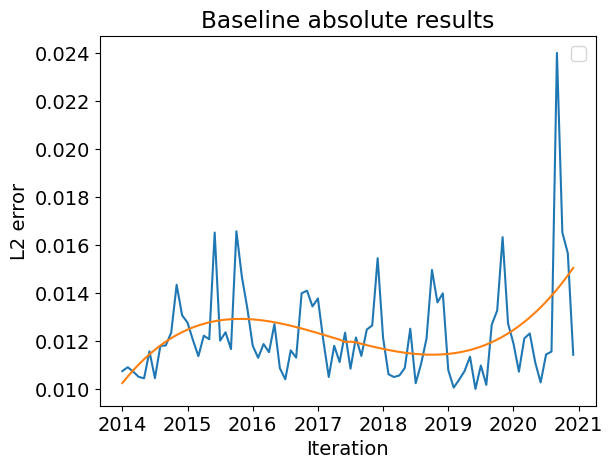

In [6]:
def _errorbar(ax, x, y, yerr, **kwargs):
    ax.errorbar(x, y, yerr, **kwargs, alpha=.75, fmt=':', capsize=3, capthick=1)
    data = {
        'x': x,
        'y1': [y - e for y, e in zip(y, yerr)],
        'y2': [y + e for y, e in zip(y, yerr)]}
    ax.fill_between(**data, **kwargs, alpha=.25)

def f_plot(ax, key_values: Dict[str, pd.DataFrame], plot_kwargs: Dict={}, fig_kwargs: Dict={}):
    """Plot one node's data for all ensembles"""

    colors = plot_kwargs.pop("colors") if "colors" in plot_kwargs else 100 * [None]
    labels = plot_kwargs.pop("labels") if "labels" in plot_kwargs else 100 * [None]
    plot_avgs = plot_kwargs.pop("plot_averages") if "plot_averages" in plot_kwargs else False
    i = 0
    for method, v in key_values.items():
        if isinstance(v, np.ndarray):
            assert len(v) in (1, 2)
            if len(v) == 1:
                v = {"l2 relative": v[0]}
            else:
                v = {"l2 relative": v[0], "l2 relative std": v[1]}
        y = v["l2 relative"]
        x = range(len(y))
        ax.plot(y, **plot_kwargs, color=colors[i], label=labels[i])
        if plot_avgs:
            ax.plot([y.mean()] * len(y), "--", **plot_kwargs, color=colors[i])

        if "l2 relative std" in v:
            _errorbar(ax, x, y, v["l2 relative std"], color=colors[i])
        i += 1

    if fig_kwargs.get("display_zeros", False):
        ax.plot([0] * len(y), "--", color="black")
    ax.set_title(fig_kwargs.get("title", None))
    ax.set_ylim(fig_kwargs.get("ylim", None))
    default_xticks = [range(len(x))]
    ax.set_xticks(*fig_kwargs.get("xticks", default_xticks))
    ax.set_xlabel(fig_kwargs.get("xlabel", "Iteration"))
    ax.set_ylabel(fig_kwargs.get("ylabel", "Relative error"))
    if fig_kwargs.get("legend", False):
        ax.legend()


print("Node => 3 iters and 84 months: ", {node: v.shape for node, v in sl_data.items()})
rel_sl_data = {node: np.array([rel(v[0], v[1]), rel(v[0], v[2])]) for node, v in sl_data.items()}
print("Node => 84 months of it2 and it3 relative to it1: ", {node: v.shape for node, v in rel_sl_data.items()})

avg_l2_sl_data = get_average(sl_data)
print(f"avg l2 sl data : {avg_l2_sl_data.shape}")
# f_plot(plt.figure().gca(), {"average l2 sl baseline": avg_l2_sl_data[0:1]})

def smooth(x, window: int):

    w = np.ones(int(window))/float(window)
    return np.convolve(x, w, 'same')

# baseline_l2 = {"l2 sl baseline": avg_l2_sl_data[0:1]}
labels = ["baseline", "iteration 2", "iteration 3"]
xticks = [[0, 12, 24, 36, 48, 60, 72, 84],
         ["2014", "2015", "2016", "2017", "2018", "2019",  "2020", "2021"] ]


data = {"baseline": avg_l2_sl_data[0: 1], "smoothed": savgol_filter(avg_l2_sl_data[0], 82, 3)[None]}
f_plot(plt.figure().gca(), data,
       fig_kwargs={"title": "Baseline absolute results" ,"legend": True, "xticks": xticks, "ylabel": "L2 error"})


# print(avg_l2_sl_data.shape)


7.798


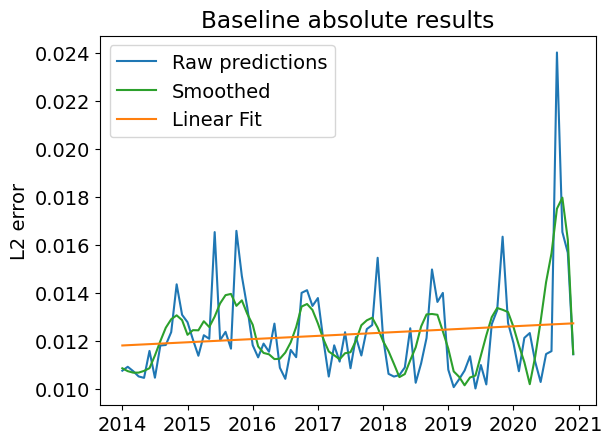

In [13]:
y = avg_l2_sl_data[0]
A = np.arange(len(y))
A = np.stack([A, [1]*len(A)], axis=1)
x = np.linalg.inv(A.T @ A) @ A.T @ y

y_linear = np.arange(len(y)) * x[0] + x[1]
avg_increase = (y_linear[-1] - y_linear[0]) / y_linear[0]
print(round(avg_increase*100, 3))
data = {"baseline": avg_l2_sl_data[0: 1], "smoothed": savgol_filter(avg_l2_sl_data[0], 10, 3)[None], "linear_fit": y_linear[None]}
f_plot(plt.figure().gca(), data, plot_kwargs={"labels": ["Raw predictions", "Smoothed", "Linear Fit"], "colors":["tab:blue", "tab:green", "tab:orange"]},
       fig_kwargs={"title": "Baseline absolute results" ,"legend": True, "xticks": xticks, "ylabel": "L2 error", "xlabel": None})


In [8]:
sl_paths = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it1_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it2_nn_test_train_right",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa//hyperedges/dump_dir_it3_nn_test_train_right",
    ]
}

sl_path_all_7 = {
    "nn_small_v2": [
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it1_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it2_nn_train",
        "/scratch/nvme0n1/ngc/ngc-analyze-dump-dir/dump_dirs/nasa/iterative_training/dump_dir_it3_nn_test",
    ]
}

active_method = "nn_small_v2"
sup_title = {"nn_small_v2": "NN-V2", "simple_mean": "S-Mean", "weighted_mean_lr": "S-LR"}[active_method]
nodes = ['AOD', 'FIRE', 'LSTD_AN', 'LSTN_AN', 'WV']
_sl_paths = {active_method: sl_paths[active_method]}
sl_data = {node: read_sl_data(_sl_paths, node)[active_method][:, 0:84] for node in nodes}
print({k: v.shape for k, v in sl_data.items()})


all_rel_data = {k: np.array([rel(sl_data[k][0], sl_data[k][1]), rel(sl_data[k][0], sl_data[k][2])]) for k in sl_data.keys()}
print({k: v.shape for k, v in all_rel_data.items()})


{'AOD': (3, 84), 'FIRE': (3, 84), 'LSTD_AN': (3, 84), 'LSTN_AN': (3, 84), 'WV': (3, 84)}
{'AOD': (2, 84), 'FIRE': (2, 84), 'LSTD_AN': (2, 84), 'LSTN_AN': (2, 84), 'WV': (2, 84)}


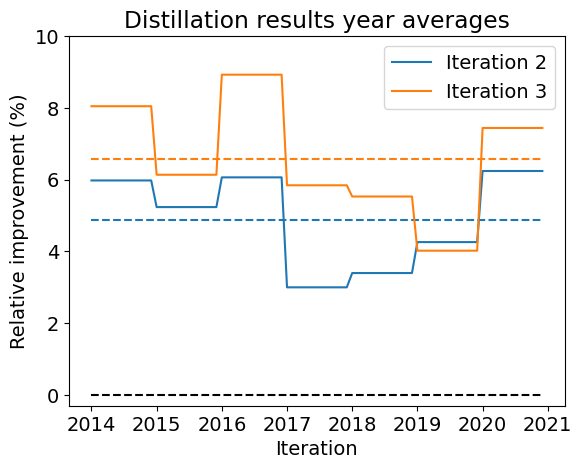

In [11]:

def year_avg(data):
    res = data * 0
    assert data.shape[-1] % 12 == 0
    n = data.shape[-1] // 12
    for i in range(n):
        res[:, i * 12: (i + 1) * 12] = (data[:, i * 12: (i + 1) * 12].mean(axis=1))[:, None]
    return res

avg_rel_data = np.stack([v for v in all_rel_data.values()]).mean(axis=0)
year_avg_rel_data = year_avg(avg_rel_data)

labels = ["baseline", "iteration 2", "iteration 3"]
xticks = [[0, 12, 24, 36, 48, 60, 72, 84],
         ["2014", "2015", "2016", "2017", "2018", "2019",  "2020", "2021"] ]

# fig_kwargs={"title": "Distillation across time" ,"legend": True, "xticks": xticks, "ylabel": "Relative error (%)"}
# plot_kwargs = {"labels": ["Iteration 2", "Iteration 3"]}
# f_plot(plt.figure().gca(), {"iteration 2": avg_rel_data[0: 1], "iteration 3": avg_rel_data[1: 2]}, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)


plot_kwargs = {"labels": ["Iteration 2", "Iteration 3"], "plot_averages": True, "colors": ["tab:blue", "tab:orange"]}
fig_kwargs={"title": "Distillation results year averages" ,"legend": True, "xticks": xticks, "ylabel": "Relative improvement (%)", "ylim": [-0.3, 10], "display_zeros": True}
f_plot(plt.figure().gca(), {"Iteration 2": year_avg_rel_data[0: 1], "Iteration 3": year_avg_rel_data[1: 2]}, plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs)
